# TRUST & SAFETY END-TO-END POC 

General-purpose AI products operate in adversarial environments. Users can misuse features in ways that degrade product quality, increase harm, and erode trust. In these settings, integrity work is building measurement and response systems that detect emerging abuse, route cases to appropriate handling, and convert discoveries into durable controls.

This script describes an end-to-end integrity pipeline with outputs written as structured tables. The goal is to provide a reference architecture for how integrity teams can connect telemetry, detection, review operations, automation, and incident response into a single measurable system. The main contribution is an operational reference architecture demonstrating how integrity systems can be engineered as a measurable workflow with clear interfaces and governance artifacts.

## What is included:
1) Raw events (head)
2) Core tables from SQL (head)
3) Monitoring metrics + alerts (head + plots)
4) Detection model eval (table head + plots)
5) Review queue + audit template (head)
6) Dedup + clustering summaries (head + plots)
7) Entity resolution (head + plots)
8) Drift (PSI) (head + plot)
9) Enforcement actions (head + plots)
10) Incident log (head)

# Global style, tight plot helpers, clean DataFrame heads
Sets up the notebook so charts look consistent, tables print nicely, and we have handy helper functions, like trimming long text, making quick plots, and checking if data has “changed shape” over time.

Sets consistent plotting style for the whole notebook, defines utility functions for time, text normalization, hashing, PSI drift, and compact plotting, and adds show_head() to print readable table heads with optional truncation for long text fields.

In [9]:
import os, re, json, time, random, hashlib, sqlite3
from dataclasses import dataclass
from datetime import datetime, timedelta, timezone
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 180)

# Consistent compact plotting style
mpl.rcParams.update({
    "figure.figsize": (8.2, 3.6),
    "figure.dpi": 120,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "lines.linewidth": 1.6,
})

def format_date_axis(ax, rotation: int = 45):
    ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=4, maxticks=8))
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    for lbl in ax.get_xticklabels():
        lbl.set_rotation(rotation)
        lbl.set_ha("right")
    ax.figure.tight_layout()

def ensure_dir(p: str) -> None:
    os.makedirs(p, exist_ok=True)

def utcnow() -> datetime:
    return datetime.now(timezone.utc)

def sha256_hex(s: str) -> str:
    return hashlib.sha256(s.encode("utf-8")).hexdigest()

def normalize_text(s: str) -> str:
    s = (s or "").lower().strip()
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r"[^\w\s\.\,\!\?\-:/@]", "", s)
    return s

def population_stability_index(expected: np.ndarray, actual: np.ndarray, bins: int = 10) -> float:
    expected = np.asarray(expected, dtype=float)
    actual = np.asarray(actual, dtype=float)
    if expected.size == 0 or actual.size == 0:
        return 0.0
    if np.all(expected == expected[0]) and np.all(actual == actual[0]):
        return 0.0
    edges = np.unique(np.quantile(expected, np.linspace(0, 1, bins + 1)))
    if len(edges) < 3:
        return 0.0

    def _hist(x):
        h, _ = np.histogram(x, bins=edges)
        h = h.astype(float)
        h = h / max(h.sum(), 1.0)
        return np.clip(h, 1e-6, 1.0)

    e = _hist(expected)
    a = _hist(actual)
    return float(np.sum((a - e) * np.log(a / e)))

def _truncate_str(x, max_len: int = 140) -> str:
    if x is None:
        return ""
    s = str(x)
    if len(s) <= max_len:
        return s
    return s[: max_len - 1] + "…"

def show_head(df: pd.DataFrame, title: str, n: int = 5, truncate_cols: List[str] | None = None, max_len: int = 140) -> None:
    print(f"\n=== {title} (shape={df.shape}) ===")
    d = df.copy()
    if truncate_cols:
        for c in truncate_cols:
            if c in d.columns:
                d[c] = d[c].map(lambda v: _truncate_str(v, max_len=max_len))
    display(d.head(n))

def show_value_counts(s: pd.Series, title: str, top_n: int = 12) -> None:
    vc = s.value_counts().head(top_n)
    print(f"\n=== {title} (top {top_n}) ===")
    display(vc.to_frame("count"))

def tight_hist(series: pd.Series, title: str, bins: int = 40, xlabel: str | None = None):
    fig, ax = plt.subplots()
    ax.hist(series.dropna().values, bins=bins)
    ax.set_title(title)
    ax.set_xlabel(xlabel if xlabel is not None else (series.name or "value"))
    ax.set_ylabel("count")
    fig.tight_layout()
    plt.show()

def tight_bar(counts: pd.Series, title: str, xlabel: str = "", ylabel: str = "count"):
    fig, ax = plt.subplots()
    counts.plot(kind="bar", ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig.tight_layout()
    plt.show()

# 1. Synthetic log generator
Creates realistic-looking “app activity logs” (simulated data) for many users over many days, including normal users and a small group acting suspiciously, with shared devices/IPs to mimic coordinated abuse.

Creates a configurable synthetic telemetry generator that simulates product events across users and days, including benign behavior, abuse-like behavior, and shared identifiers (IP, device, payment) to enable later clustering and entity resolution.

In [12]:
@dataclass
class GenConfig:
    n_users: int = 1500
    n_events: int = 50000
    duration_days: int = 14
    abuse_rate: float = 0.04
    seed: int = 42

def generate_synthetic_events(cfg: GenConfig) -> pd.DataFrame:
    rng = np.random.default_rng(cfg.seed)
    random.seed(cfg.seed)

    user_ids = [f"u_{i:05d}" for i in range(cfg.n_users)]
    n_actor_clusters = max(3, cfg.n_users // 500)
    actor_cluster_ids = [f"actor_{i:02d}" for i in range(n_actor_clusters)]

    ip_pool = [f"203.0.113.{i}" for i in range(1, 230)]
    device_pool = [f"dev_{i:06d}" for i in range(1, cfg.n_users * 2)]
    pay_pool = [f"pay_{i:06d}" for i in range(1, cfg.n_users // 2 + 50)]

    user_meta = {}
    for u in user_ids:
        user_meta[u] = {
            "ip": random.choice(ip_pool),
            "device": random.choice(device_pool),
            "payment": (random.choice(pay_pool) if random.random() < 0.65 else None),
        }

    # choose abusers
    abuse_users = set(rng.choice(user_ids, size=int(cfg.n_users * cfg.abuse_rate), replace=False).tolist())
    abuse_users_list = list(abuse_users)
    for i, u in enumerate(abuse_users_list):
        cluster = actor_cluster_ids[i % n_actor_clusters]
        user_meta[u]["ip"] = f"198.51.100.{(i % 30) + 1}"
        user_meta[u]["device"] = f"dev_shared_{cluster}_{(i % 10):02d}"

    event_types = ["signup", "login", "chat", "upload", "billing", "policy_block", "warning"]
    surfaces = ["web", "ios", "android", "api"]
    products = ["chat", "assistants", "files", "images"]

    benign_prompts = [
        "Summarize this article in simple terms.",
        "Help me draft a professional email to my team.",
        "Explain the difference between mitosis and meiosis.",
        "Generate Python code to parse a CSV and compute averages.",
        "Brainstorm names for a new biotech startup.",
        "Translate this paragraph into Spanish.",
        "Make a study plan for learning linear algebra.",
    ]
    repetitive_prompts = [
        "Buy now buy now buy now!!!",
        "Click this link for free prizes!!!",
        "Limited offer, act fast!!!",
        "Join our group and earn money quickly!!!",
    ]
    policy_edge_prompts = [
        "How do I bypass content filters?",
        "Can you help me evade detection systems?",
        "Write something that breaks the rules, but hide it.",
    ]

    start_time = utcnow() - timedelta(days=cfg.duration_days)
    end_time = start_time + timedelta(days=cfg.duration_days)

    def rand_time():
        delta = (end_time - start_time).total_seconds()
        return start_time + timedelta(seconds=float(rng.uniform(0, delta)))

    rows = []
    for i in range(cfg.n_events):
        u = random.choice(user_ids)
        is_abuser = u in abuse_users
        meta = user_meta[u]

        et = rng.choice(
            event_types,
            p=[0.01, 0.07, 0.72, 0.08, 0.03, 0.06, 0.03] if is_abuser
              else [0.01, 0.12, 0.63, 0.10, 0.06, 0.04, 0.04]
        )

        ts = pd.to_datetime(rand_time(), utc=True)
        surface = random.choice(surfaces)
        product = random.choice(products)

        prompt = ""
        if et == "chat":
            if is_abuser and random.random() < 0.55:
                prompt = random.choice(repetitive_prompts if random.random() < 0.7 else policy_edge_prompts)
            else:
                prompt = random.choice(benign_prompts)

        tokens_in = int(max(1, rng.normal(220 if et == "chat" else 30, 80)))
        tokens_out = int(max(1, rng.normal(260 if et == "chat" else 20, 120)))

        blocked = 0
        warned = 0
        if is_abuser and et == "chat":
            if ("bypass" in prompt) or ("evade" in prompt) or ("break the rules" in prompt):
                blocked = 1 if random.random() < 0.6 else 0
                warned = 1 if (blocked == 0 and random.random() < 0.5) else 0
            elif prompt in repetitive_prompts:
                warned = 1 if random.random() < 0.25 else 0

        if et == "policy_block":
            blocked = 1
        if et == "warning":
            warned = 1

        latency_ms = int(max(5, rng.normal(900, 300))) if et == "chat" else int(max(5, rng.normal(180, 90)))

        rows.append({
            "event_id": f"e_{i:09d}",
            "ts": ts,
            "user_id": u,
            "ip": meta["ip"],
            "device_id": meta["device"],
            "payment_id": meta.get("payment"),
            "surface": surface,
            "product": product,
            "event_type": et,
            "prompt": prompt,
            "tokens_in": tokens_in,
            "tokens_out": tokens_out,
            "latency_ms": latency_ms,
            "blocked": blocked,
            "warned": warned,
            "is_abuse_gt": int(is_abuser),
        })

    df = pd.DataFrame(rows).sort_values("ts").reset_index(drop=True)
    return df

 # 2. Generate data and sanity-check visuals
Runs the generator to produce the raw events DataFrame, prints the head, shows event-type counts, and plots two quick health-check charts, event-type bar chart and events-per-day line plot.

Generates the simulated logs, shows the first few rows, counts the types of events, and draws a couple of quick charts to confirm the data looks normal (volume by day, event types).


=== RAW EVENTS (shape=(50000, 16)) ===


,event_id,ts,user_id,ip,device_id,payment_id,surface,product,event_type,prompt,tokens_in,tokens_out,latency_ms,blocked,warned,is_abuse_gt
0,e_000002004,2026-02-01 05:26:54.143876+00:00,u_01172,203.0.113.161,dev_000606,None,android,assistants,chat,Generate Python code to parse a CSV and comput...,296,369,1138,0,0,0
1,e_000027492,2026-02-01 05:27:09.424081+00:00,u_01107,203.0.113.52,dev_000535,pay_000182,ios,files,chat,Summarize this article in simple terms.,308,428,769,0,0,0
2,e_000026091,2026-02-01 05:27:32.723091+00:00,u_00314,203.0.113.127,dev_000152,pay_000605,ios,files,chat,Help me draft a professional email to my team.,223,241,1039,0,0,0
3,e_000009969,2026-02-01 05:27:53.371681+00:00,u_01311,203.0.113.34,dev_001979,None,web,chat,chat,Explain the difference between mitosis and mei...,207,248,1130,0,0,0
4,e_000041712,2026-02-01 05:28:08.068000+00:00,u_00790,203.0.113.222,dev_000907,None,android,files,login,,66,1,330,0,0,0



=== Raw events by type (top 12) ===


,count
event_type,
chat,31715
login,5846
upload,4889
billing,2943
policy_block,2034
warning,2013
signup,560


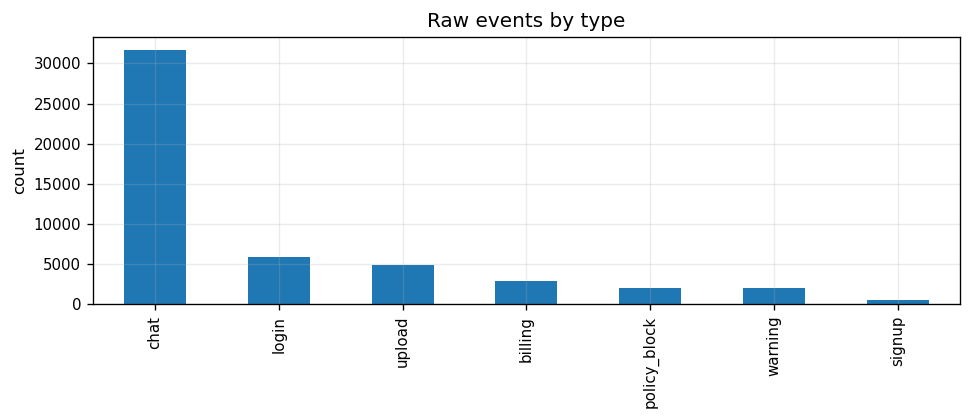

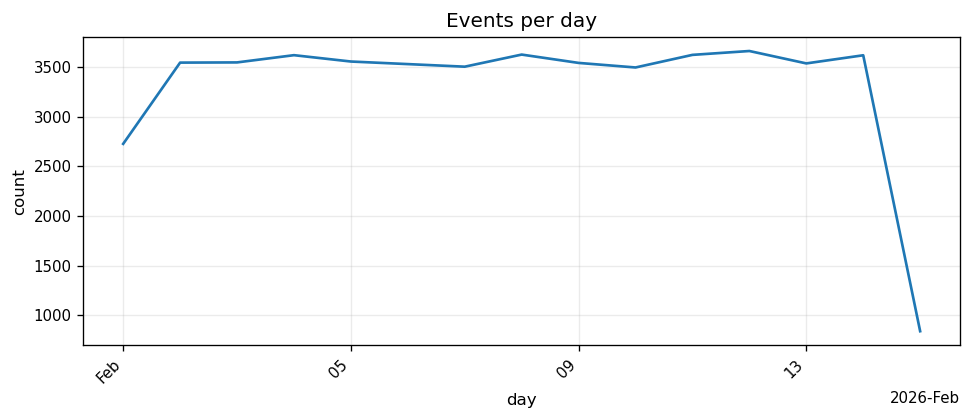

In [14]:
OUTDIR = "out_notebook"
ensure_dir(OUTDIR)
DB_PATH = os.path.join(OUTDIR, "sqlite.db")

cfg = GenConfig(n_users=1500, n_events=50000, duration_days=14, abuse_rate=0.04, seed=42)
events = generate_synthetic_events(cfg)

show_head(events, "RAW EVENTS", truncate_cols=["prompt"], max_len=120)
show_value_counts(events["event_type"], "Raw events by type")

# Raw events by type
tight_bar(events["event_type"].value_counts(), "Raw events by type")

# Events per day
events_per_day = events.groupby(events["ts"].dt.floor("D"))["event_id"].count()
fig, ax = plt.subplots()
ax.plot(events_per_day.index, events_per_day.values)
ax.set_title("Events per day")
ax.set_xlabel("day")
ax.set_ylabel("count")
format_date_axis(ax)
plt.show()

# 3. SQLite write + core tables
Writes raw events into SQLite, builds indexed tables, and materializes three “core tables” using SQL, core_users, core_user_day, and core_day_metrics, then prints heads of each core table.

Stores the raw logs in a small database (SQLite) and builds clean summary tables, like “per user,” “per user per day,” and “per day,” so dashboards and analysis are fast and reliable.

In [16]:
def write_to_sqlite(df_events: pd.DataFrame, db_path: str) -> None:
    if os.path.exists(db_path):
        os.remove(db_path)

    con = sqlite3.connect(db_path)
    try:
        dfw = df_events.copy()
        dfw["ts"] = dfw["ts"].dt.strftime("%Y-%m-%dT%H:%M:%S%z")
        dfw.to_sql("raw_events", con, index=False)

        con.execute("CREATE INDEX idx_raw_ts ON raw_events(ts)")
        con.execute("CREATE INDEX idx_raw_user ON raw_events(user_id)")
        con.execute("CREATE INDEX idx_raw_ip ON raw_events(ip)")
        con.execute("CREATE INDEX idx_raw_device ON raw_events(device_id)")
        con.commit()

        con.executescript("""
            DROP TABLE IF EXISTS core_users;
            CREATE TABLE core_users AS
            SELECT
                user_id,
                MIN(ts) AS first_seen_ts,
                MAX(ts) AS last_seen_ts,
                COUNT(*) AS n_events,
                SUM(CASE WHEN event_type='chat' THEN 1 ELSE 0 END) AS n_chat,
                SUM(CASE WHEN blocked=1 THEN 1 ELSE 0 END) AS n_blocked,
                SUM(CASE WHEN warned=1 THEN 1 ELSE 0 END) AS n_warned,
                COUNT(DISTINCT ip) AS n_ips,
                COUNT(DISTINCT device_id) AS n_devices,
                COUNT(DISTINCT COALESCE(payment_id, 'none')) AS n_payments
            FROM raw_events
            GROUP BY user_id;

            DROP TABLE IF EXISTS core_user_day;
            CREATE TABLE core_user_day AS
            SELECT
                substr(ts, 1, 10) AS day,
                user_id,
                COUNT(*) AS n_events,
                SUM(CASE WHEN event_type='chat' THEN 1 ELSE 0 END) AS n_chat,
                SUM(tokens_in) AS tokens_in_sum,
                SUM(tokens_out) AS tokens_out_sum,
                AVG(latency_ms) AS latency_ms_avg,
                SUM(blocked) AS n_blocked,
                SUM(warned) AS n_warned,
                COUNT(DISTINCT ip) AS n_ips,
                COUNT(DISTINCT device_id) AS n_devices,
                MAX(is_abuse_gt) AS is_abuse_gt
            FROM raw_events
            GROUP BY day, user_id;

            DROP TABLE IF EXISTS core_day_metrics;
            CREATE TABLE core_day_metrics AS
            SELECT
                substr(ts, 1, 10) AS day,
                COUNT(*) AS n_events,
                SUM(CASE WHEN event_type='chat' THEN 1 ELSE 0 END) AS n_chat,
                COUNT(DISTINCT user_id) AS n_active_users,
                SUM(blocked) AS n_blocked,
                SUM(warned) AS n_warned,
                AVG(latency_ms) AS latency_ms_avg
            FROM raw_events
            GROUP BY day
            ORDER BY day;
        """)
        con.commit()
    finally:
        con.close()

def sql_df(db_path: str, query: str) -> pd.DataFrame:
    con = sqlite3.connect(db_path)
    try:
        return pd.read_sql_query(query, con)
    finally:
        con.close()

write_to_sqlite(events, DB_PATH)

core_users = sql_df(DB_PATH, "SELECT * FROM core_users ORDER BY n_events DESC")
core_user_day = sql_df(DB_PATH, "SELECT * FROM core_user_day ORDER BY day DESC, n_events DESC")
core_day_metrics = sql_df(DB_PATH, "SELECT * FROM core_day_metrics ORDER BY day")

show_head(core_users, "CORE USERS")
show_head(core_user_day, "CORE USER-DAY")
show_head(core_day_metrics, "CORE DAY METRICS")


=== CORE USERS (shape=(1500, 10)) ===


,user_id,first_seen_ts,last_seen_ts,n_events,n_chat,n_blocked,n_warned,n_ips,n_devices,n_payments
0,u_00006,2026-02-01T09:24:52+0000,2026-02-15T05:14:05+0000,51,31,0,1,1,1,1
1,u_01247,2026-02-01T05:37:18+0000,2026-02-14T04:22:29+0000,51,31,2,2,1,1,1
2,u_00899,2026-02-01T12:48:56+0000,2026-02-14T23:26:45+0000,50,31,4,4,1,1,1
3,u_00223,2026-02-01T16:48:40+0000,2026-02-15T03:31:27+0000,49,33,1,0,1,1,1
4,u_00425,2026-02-01T05:33:28+0000,2026-02-13T16:22:44+0000,49,28,2,4,1,1,1



=== CORE USER-DAY (shape=(19596, 12)) ===


,day,user_id,n_events,n_chat,tokens_in_sum,tokens_out_sum,latency_ms_avg,n_blocked,n_warned,n_ips,n_devices,is_abuse_gt
0,2026-02-15,u_00388,4,3,729,804,641.000000,1,0,1,1,0
1,2026-02-15,u_00636,4,3,918,695,779.000000,0,0,1,1,0
2,2026-02-15,u_00022,3,2,470,476,652.000000,0,0,1,1,0
3,2026-02-15,u_00083,3,2,696,732,557.666667,0,0,1,1,0
4,2026-02-15,u_00094,3,2,479,896,782.666667,1,0,1,1,1



=== CORE DAY METRICS (shape=(15, 7)) ===


,day,n_events,n_chat,n_active_users,n_blocked,n_warned,latency_ms_avg
0,2026-02-01,2728,1747,1242,126,123,628.945748
1,2026-02-02,3547,2272,1372,153,170,637.985058
2,2026-02-03,3549,2269,1349,169,151,637.450549
3,2026-02-04,3622,2259,1371,184,168,622.968250
4,2026-02-05,3558,2264,1373,148,141,639.833895


# 4. Monitoring metrics + alerts (tight plots)
Computes daily monitoring metrics (block rate, warn rate, volumes) from core_day_metrics, applies simple anomaly rules to produce alerts, prints heads of metrics and alerts, and plots compact time-series monitoring charts.

Calculates daily health metrics, like how often warnings/blocks happen, and triggers simple alerts when something spikes, then plots the trends so you can spot problems quickly.


=== MONITORING METRICS (shape=(15, 9)) ===


,day,n_events,n_chat,n_active_users,n_blocked,n_warned,latency_ms_avg,block_rate,warn_rate
0,2026-02-01,2728,1747,1242,126,123,628.945748,0.072124,0.070406
1,2026-02-02,3547,2272,1372,153,170,637.985058,0.067342,0.074824
2,2026-02-03,3549,2269,1349,169,151,637.450549,0.074482,0.066549
3,2026-02-04,3622,2259,1371,184,168,622.968250,0.081452,0.074369
4,2026-02-05,3558,2264,1373,148,141,639.833895,0.065371,0.062279



=== ALERTS (shape=(2, 4)) ===


,day,alert_type,severity,details
0,2026-02-04,spike_block_rate,high,"block_rate=0.081, n_chat=2259"
1,2026-02-15,spike_block_rate,high,"block_rate=0.088, n_chat=544"


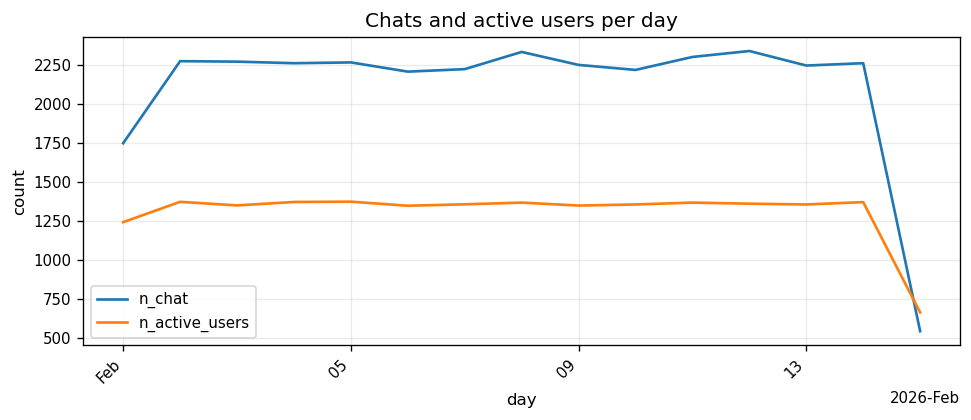

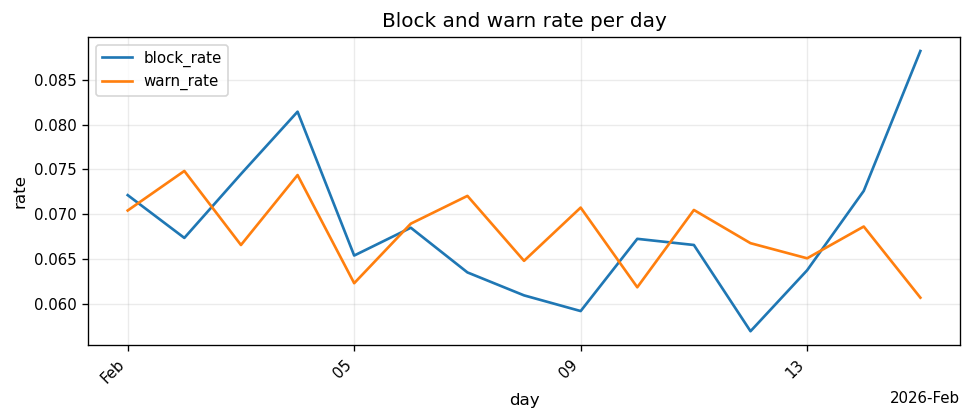

In [19]:
def build_monitoring_metrics(db_path: str) -> pd.DataFrame:
    df = sql_df(db_path, "SELECT * FROM core_day_metrics")
    df["block_rate"] = df["n_blocked"] / df["n_chat"].replace(0, np.nan)
    df["warn_rate"] = df["n_warned"] / df["n_chat"].replace(0, np.nan)
    return df.fillna(0.0)

def generate_alerts(metrics: pd.DataFrame) -> pd.DataFrame:
    alerts = []
    for _, r in metrics.iterrows():
        day = r["day"]
        if r["block_rate"] > 0.08 and r["n_chat"] > 500:
            alerts.append({"day": day, "alert_type": "spike_block_rate", "severity": "high",
                           "details": f"block_rate={r['block_rate']:.3f}, n_chat={int(r['n_chat'])}"})
        if r["n_active_users"] > 0 and (r["n_chat"] / r["n_active_users"]) > 80:
            alerts.append({"day": day, "alert_type": "high_chat_per_user", "severity": "medium",
                           "details": f"chat_per_active_user={(r['n_chat']/r['n_active_users']):.1f}"})
    return pd.DataFrame(alerts)

metrics = build_monitoring_metrics(DB_PATH)
alerts = generate_alerts(metrics)

show_head(metrics, "MONITORING METRICS")
show_head(alerts, "ALERTS")

m = metrics.copy()
m["day_dt"] = pd.to_datetime(m["day"])

# Chats + active users
fig, ax = plt.subplots()
ax.plot(m["day_dt"], m["n_chat"], label="n_chat")
ax.plot(m["day_dt"], m["n_active_users"], label="n_active_users")
ax.set_title("Chats and active users per day")
ax.set_xlabel("day")
ax.set_ylabel("count")
ax.legend()
format_date_axis(ax)
plt.show()

# Block/warn rates
fig, ax = plt.subplots()
ax.plot(m["day_dt"], m["block_rate"], label="block_rate")
ax.plot(m["day_dt"], m["warn_rate"], label="warn_rate")
ax.set_title("Block and warn rate per day")
ax.set_xlabel("day")
ax.set_ylabel("rate")
ax.legend()
format_date_axis(ax)
plt.show()

# 5. User-day signals (features)
Creates the user-day feature table used for detection, adds derived rates (block rate, warn rate, chat fraction), defines the final feature list, and ensures all feature columns are numeric and missing-safe.

Makes the key numbers that often indicate abuse, like lots of chats in a day, many IPs/devices, high block rate, high warning rate, etc. These become the inputs to the detector.

In [22]:
def compute_user_day_signals(db_path: str) -> pd.DataFrame:
    q = """
    SELECT
        day,
        user_id,
        n_events,
        n_chat,
        tokens_in_sum,
        tokens_out_sum,
        latency_ms_avg,
        n_blocked,
        n_warned,
        n_ips,
        n_devices,
        is_abuse_gt,
        CASE WHEN n_chat > 0 THEN (1.0 * n_blocked) / n_chat ELSE 0.0 END AS block_rate,
        CASE WHEN n_chat > 0 THEN (1.0 * n_warned) / n_chat ELSE 0.0 END AS warn_rate,
        CASE WHEN n_events > 0 THEN (1.0 * n_chat) / n_events ELSE 0.0 END AS chat_fraction
    FROM core_user_day
    """
    return sql_df(db_path, q)

df_ud = compute_user_day_signals(DB_PATH)
show_head(df_ud, "USER-DAY SIGNALS")

FEATURE_COLS = [
    "n_events", "n_chat", "tokens_in_sum", "tokens_out_sum", "latency_ms_avg",
    "n_blocked", "n_warned", "n_ips", "n_devices",
    "block_rate", "warn_rate", "chat_fraction"
]
for c in FEATURE_COLS:
    df_ud[c] = pd.to_numeric(df_ud[c], errors="coerce").fillna(0.0)


=== USER-DAY SIGNALS (shape=(19596, 15)) ===


,day,user_id,n_events,n_chat,tokens_in_sum,tokens_out_sum,latency_ms_avg,n_blocked,n_warned,n_ips,n_devices,is_abuse_gt,block_rate,warn_rate,chat_fraction
0,2026-02-01,u_00000,2,1,379,214,454.000000,0,0,1,1,0,0.0,0.0,0.5
1,2026-02-01,u_00001,2,2,435,416,1037.000000,0,0,1,1,0,0.0,0.0,1.0
2,2026-02-01,u_00002,1,0,1,66,470.000000,0,0,1,1,0,0.0,0.0,0.0
3,2026-02-01,u_00003,3,0,123,303,173.666667,0,0,1,1,0,0.0,0.0,0.0
4,2026-02-01,u_00006,4,2,416,547,418.750000,0,0,1,1,0,0.0,0.0,0.5


# 6. Train detection model + PR curve + score distributions
Trains a baseline logistic regression model on user-day features, selects an operating threshold via an F1 sweep, prints evaluation metrics, scores all user-days, derives an uncertainty proxy, and visualizes score distributions plus the precision–recall curve.

Trains a basic model to give each user-day a “risk score” from 0 to 1, picks a cutoff point, estimates how unsure the model is, and shows charts so you can see the separation between normal and risky behavior.


=== MODEL EVALUATION (shape=(1, 5)) ===


,threshold,test_precision,test_recall,test_f1,test_auc
0,0.78,0.547619,0.234694,0.328571,0.695804


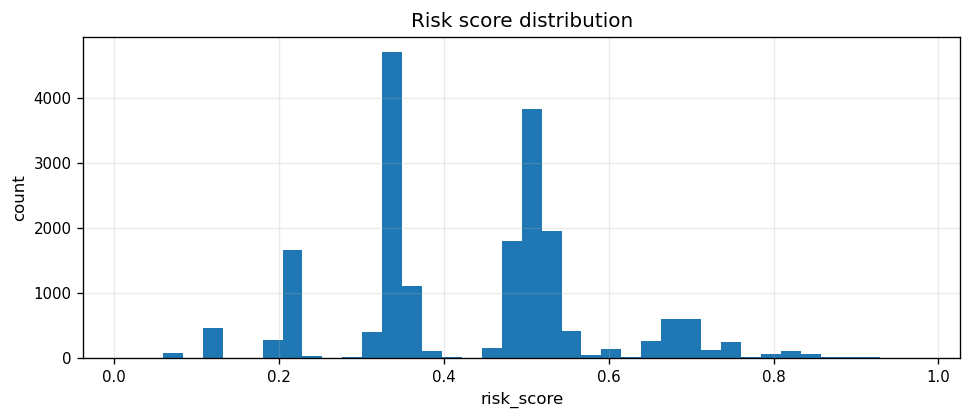

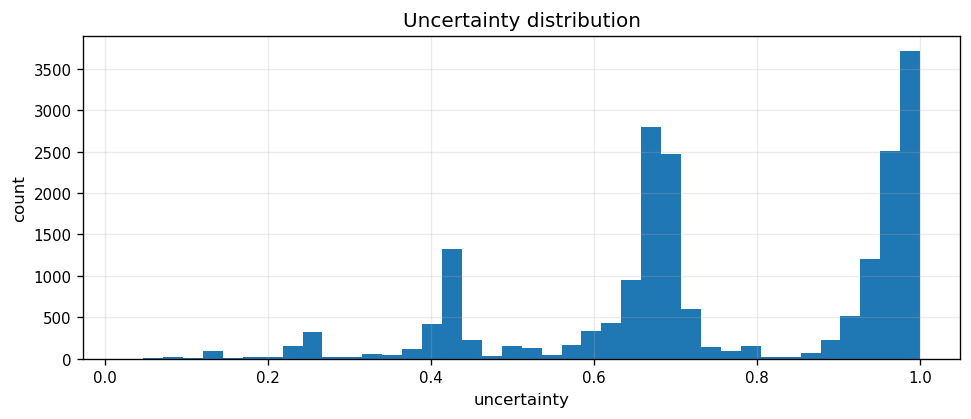

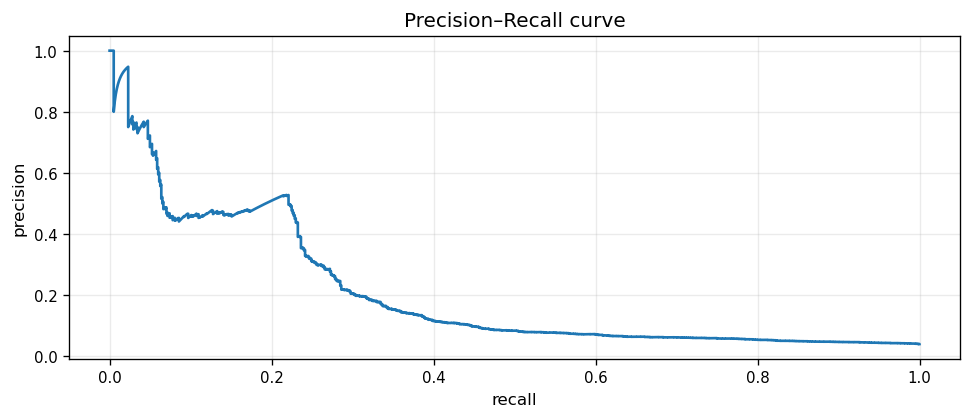

In [25]:
def train_detection_model(df_ud: pd.DataFrame, feature_cols: List[str]) -> Dict[str, object]:
    y = df_ud["is_abuse_gt"].astype(int).values
    X = df_ud[feature_cols].astype(float).values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y
    )

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=300, class_weight="balanced", n_jobs=1)),
    ])
    pipe.fit(X_train, y_train)

    proba_train = pipe.predict_proba(X_train)[:, 1]
    proba_test = pipe.predict_proba(X_test)[:, 1]

    best_thr, best_f1 = 0.5, -1.0
    for thr in np.linspace(0.1, 0.9, 81):
        pred = (proba_train >= thr).astype(int)
        p, r, f1, _ = precision_recall_fscore_support(y_train, pred, average="binary", zero_division=0)
        if f1 > best_f1:
            best_f1, best_thr = float(f1), float(thr)

    pred_test = (proba_test >= best_thr).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(y_test, pred_test, average="binary", zero_division=0)
    auc = roc_auc_score(y_test, proba_test) if len(np.unique(y_test)) > 1 else np.nan

    eval_df = pd.DataFrame([{
        "threshold": best_thr,
        "test_precision": float(p),
        "test_recall": float(r),
        "test_f1": float(f1),
        "test_auc": float(auc) if not np.isnan(auc) else np.nan,
    }])

    return {"model": pipe, "threshold": best_thr, "eval": eval_df}

model_out = train_detection_model(df_ud, FEATURE_COLS)
show_head(model_out["eval"], "MODEL EVALUATION")

pipe = model_out["model"]
thr = float(model_out["threshold"])

df_scored = df_ud.copy()
df_scored["risk_score"] = pipe.predict_proba(df_scored[FEATURE_COLS].values)[:, 1]
df_scored["uncertainty"] = 1.0 - np.abs(df_scored["risk_score"] - 0.5) * 2.0

tight_hist(df_scored["risk_score"].rename("risk_score"), "Risk score distribution")
tight_hist(df_scored["uncertainty"].rename("uncertainty"), "Uncertainty distribution")

# Precision–Recall curve
y = df_scored["is_abuse_gt"].astype(int).values
scores = df_scored["risk_score"].values
prec, rec, _ = precision_recall_curve(y, scores)

fig, ax = plt.subplots()
ax.plot(rec, prec)
ax.set_title("Precision–Recall curve")
ax.set_xlabel("recall")
ax.set_ylabel("precision")
fig.tight_layout()
plt.show()

# 7. Review queue (human-in-the-loop) + audit template (clean heads)
Builds a prioritized review queue by combining model flags, heuristic flags, and uncertainty routing, enriches cases with recent prompt snippets, and generates an audit log template for reviewer decisions, then shows queue and audit heads and plots queue score distribution.

Creates a prioritized list of cases for humans to review, adds helpful context (recent prompts), and outputs an audit log template so every decision is recorded clearly.


=== REVIEW QUEUE (PRIORITIZED) (shape=(2000, 24)) ===


,day,user_id,n_events,n_chat,tokens_in_sum,tokens_out_sum,latency_ms_avg,n_blocked,n_warned,n_ips,n_devices,is_abuse_gt,block_rate,warn_rate,chat_fraction,risk_score,uncertainty,heuristic_score,flag_ml,flag_heur,flag_uncertain,needs_review,recent_prompts,priority
0,2026-02-11,u_00065,8,6,1381,1945,954.50,1,2,1,1,1,0.166667,0.333333,0.75,0.958444,0.083112,0.622636,1,0,0,1,join our group and earn money quickly!!! | how...,0.657611
1,2026-02-12,u_01144,5,4,728,950,757.60,1,2,1,1,1,0.250000,0.500000,0.80,0.976138,0.047725,0.857748,1,1,0,1,how do i bypass content filters? | click this ...,0.656034
2,2026-02-11,u_00334,5,4,1036,956,613.40,1,2,1,1,1,0.250000,0.500000,0.80,0.975657,0.048685,0.857748,1,1,0,1,can you help me evade detection systems? | gen...,0.655914
3,2026-02-11,u_01416,4,3,598,607,692.25,1,2,1,1,1,0.333333,0.666667,0.75,0.975871,0.048258,1.000000,1,1,0,1,join our group and earn money quickly!!! | joi...,0.652968
4,2026-02-01,u_00697,4,4,639,1252,861.00,2,0,1,1,1,0.500000,0.000000,1.00,0.961215,0.077570,0.955123,1,1,0,1,join our group and earn money quickly!!! | buy...,0.652304



=== AUDIT LOG TEMPLATE (shape=(2000, 11)) ===


,day,user_id,risk_score,uncertainty,recent_prompts,review_id,reviewer,decision,reason_code,notes,decision_ts
0,2026-02-11,u_00065,0.958444,0.083112,join our group and earn money quickly!!! | how...,rev_000000,,,,,
1,2026-02-12,u_01144,0.976138,0.047725,how do i bypass content filters? | click this ...,rev_000001,,,,,
2,2026-02-11,u_00334,0.975657,0.048685,can you help me evade detection systems? | gen...,rev_000002,,,,,
3,2026-02-11,u_01416,0.975871,0.048258,join our group and earn money quickly!!! | joi...,rev_000003,,,,,
4,2026-02-01,u_00697,0.961215,0.077570,join our group and earn money quickly!!! | buy...,rev_000004,,,,,


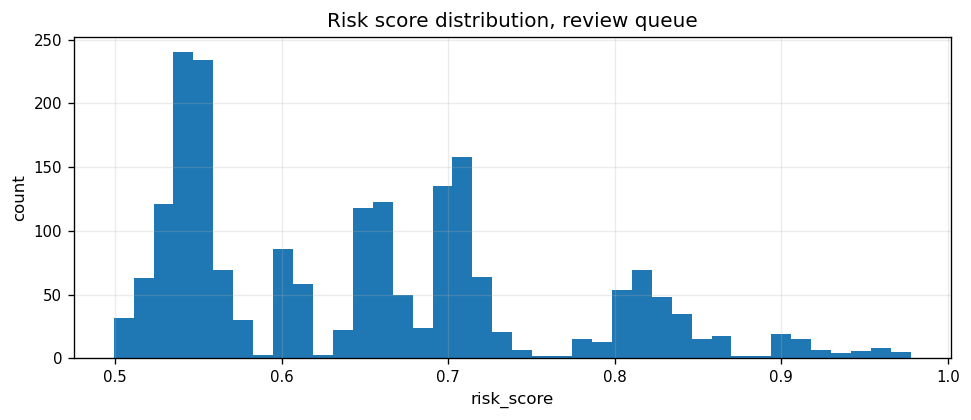

In [28]:
def baseline_heuristic_score(df_ud_scored: pd.DataFrame) -> np.ndarray:
    score = (
        0.35 * np.clip(df_ud_scored["n_chat"] / 50.0, 0, 3) +
        0.35 * np.clip(df_ud_scored["block_rate"] / 0.10, 0, 3) +
        0.15 * np.clip(df_ud_scored["n_ips"] / 3.0, 0, 3) +
        0.15 * np.clip(df_ud_scored["n_warned"] / 5.0, 0, 3)
    )
    score = score / (score.max() + 1e-9)
    return score

def build_review_queue(df_ud_scored: pd.DataFrame, events: pd.DataFrame, model_threshold: float) -> Tuple[pd.DataFrame, pd.DataFrame]:
    q = df_ud_scored.copy()

    q["heuristic_score"] = baseline_heuristic_score(q)
    q["flag_ml"] = (q["risk_score"] >= model_threshold).astype(int)
    q["flag_heur"] = (q["heuristic_score"] >= 0.75).astype(int)
    q["flag_uncertain"] = ((q["uncertainty"] >= 0.75) & (q["risk_score"] >= 0.35)).astype(int)
    q["needs_review"] = ((q["flag_ml"] + q["flag_heur"] + q["flag_uncertain"]) > 0).astype(int)

    ev = events.copy()
    ev["day"] = ev["ts"].dt.strftime("%Y-%m-%d")
    ev["prompt_norm"] = ev["prompt"].fillna("").map(normalize_text)
    ev_chat = ev[ev["event_type"] == "chat"].sort_values("ts")

    recent_map = (
        ev_chat.groupby(["day", "user_id"])["prompt_norm"]
        .apply(lambda s: " | ".join([p for p in s.tail(3).tolist() if p]))
        .reset_index()
        .rename(columns={"prompt_norm": "recent_prompts"})
    )

    q = q.merge(recent_map, on=["day", "user_id"], how="left")
    q["recent_prompts"] = q["recent_prompts"].fillna("")

    q["priority"] = (0.65 * q["risk_score"] + 0.20 * q["uncertainty"] + 0.15 * np.clip(q["n_chat"] / 50.0, 0, 1))
    queue = q[q["needs_review"] == 1].sort_values(["priority", "risk_score"], ascending=False).head(2000).reset_index(drop=True)

    audit = queue[["day", "user_id", "risk_score", "uncertainty", "recent_prompts"]].copy()
    audit["review_id"] = [f"rev_{i:06d}" for i in range(len(audit))]
    audit["reviewer"] = ""
    audit["decision"] = ""       # allow, warn, rate_limit, block, escalate
    audit["reason_code"] = ""    # spam, policy_evasion, coordinated_abuse, false_positive
    audit["notes"] = ""
    audit["decision_ts"] = ""

    return queue, audit

queue, audit = build_review_queue(df_scored, events, thr)

show_head(queue, "REVIEW QUEUE (PRIORITIZED)", truncate_cols=["recent_prompts"], max_len=140)
show_head(audit, "AUDIT LOG TEMPLATE", truncate_cols=["recent_prompts"], max_len=140)

tight_hist(queue["risk_score"].rename("risk_score"), "Risk score distribution, review queue")

# 8. Deduplication + clustering (tight summaries)
Marks duplicate cases using a hashed normalized text key, quantifies duplicate fraction, clusters non-duplicate cases using TF-IDF plus mini-batch k-means, prints the key outputs, and plots the largest cluster sizes to reveal dominant patterns.

Finds duplicates so people don’t review the same thing repeatedly, then groups similar cases into clusters so analysts can spot repeated patterns and deal with them in bulk.


=== REVIEW QUEUE (DEDUP ANNOTATED) (shape=(2000, 26)) ===


,day,user_id,n_events,n_chat,tokens_in_sum,tokens_out_sum,latency_ms_avg,n_blocked,n_warned,n_ips,n_devices,is_abuse_gt,block_rate,warn_rate,chat_fraction,risk_score,uncertainty,heuristic_score,flag_ml,flag_heur,flag_uncertain,needs_review,recent_prompts,priority,dedup_key,is_dup
0,2026-02-11,u_00065,8,6,1381,1945,954.50,1,2,1,1,1,0.166667,0.333333,0.75,0.958444,0.083112,0.622636,1,0,0,1,join our group and earn money quickly!!! | how...,0.657611,9df8e606b878b7615cda3305a6a1d13ca5bc15e836b640...,0
1,2026-02-12,u_01144,5,4,728,950,757.60,1,2,1,1,1,0.250000,0.500000,0.80,0.976138,0.047725,0.857748,1,1,0,1,how do i bypass content filters? | click this ...,0.656034,be06ce92f9e1e18b2adc61a51b91cabf1cb40ebfc7a2d4...,0
2,2026-02-11,u_00334,5,4,1036,956,613.40,1,2,1,1,1,0.250000,0.500000,0.80,0.975657,0.048685,0.857748,1,1,0,1,can you help me evade detection systems? | gen...,0.655914,8d20679a7fb4de018081927b7a5788a73bb7c3d8427bab...,0
3,2026-02-11,u_01416,4,3,598,607,692.25,1,2,1,1,1,0.333333,0.666667,0.75,0.975871,0.048258,1.000000,1,1,0,1,join our group and earn money quickly!!! | joi...,0.652968,6039f49408ee4f889842211aacc9c9746da89cf382b9be...,0
4,2026-02-01,u_00697,4,4,639,1252,861.00,2,0,1,1,1,0.500000,0.000000,1.00,0.961215,0.077570,0.955123,1,1,0,1,join our group and earn money quickly!!! | buy...,0.652304,51b7901c847dd85dbea04795cb917f95ae7b16da289431...,0



Duplicate fraction in queue: 0.44

=== CLUSTERED CASES (NON-DUP) (shape=(1120, 27)) ===


,day,user_id,n_events,n_chat,tokens_in_sum,tokens_out_sum,latency_ms_avg,n_blocked,n_warned,n_ips,n_devices,is_abuse_gt,block_rate,warn_rate,chat_fraction,risk_score,uncertainty,heuristic_score,flag_ml,flag_heur,flag_uncertain,needs_review,recent_prompts,priority,dedup_key,is_dup,cluster_id
0,2026-02-11,u_00065,8,6,1381,1945,954.50,1,2,1,1,1,0.166667,0.333333,0.75,0.958444,0.083112,0.622636,1,0,0,1,join our group and earn money quickly!!! | how...,0.657611,9df8e606b878b7615cda3305a6a1d13ca5bc15e836b640...,0,19
1,2026-02-12,u_01144,5,4,728,950,757.60,1,2,1,1,1,0.250000,0.500000,0.80,0.976138,0.047725,0.857748,1,1,0,1,how do i bypass content filters? | click this ...,0.656034,be06ce92f9e1e18b2adc61a51b91cabf1cb40ebfc7a2d4...,0,11
2,2026-02-11,u_00334,5,4,1036,956,613.40,1,2,1,1,1,0.250000,0.500000,0.80,0.975657,0.048685,0.857748,1,1,0,1,can you help me evade detection systems? | gen...,0.655914,8d20679a7fb4de018081927b7a5788a73bb7c3d8427bab...,0,19
3,2026-02-11,u_01416,4,3,598,607,692.25,1,2,1,1,1,0.333333,0.666667,0.75,0.975871,0.048258,1.000000,1,1,0,1,join our group and earn money quickly!!! | joi...,0.652968,6039f49408ee4f889842211aacc9c9746da89cf382b9be...,0,19
4,2026-02-01,u_00697,4,4,639,1252,861.00,2,0,1,1,1,0.500000,0.000000,1.00,0.961215,0.077570,0.955123,1,1,0,1,join our group and earn money quickly!!! | buy...,0.652304,51b7901c847dd85dbea04795cb917f95ae7b16da289431...,0,6


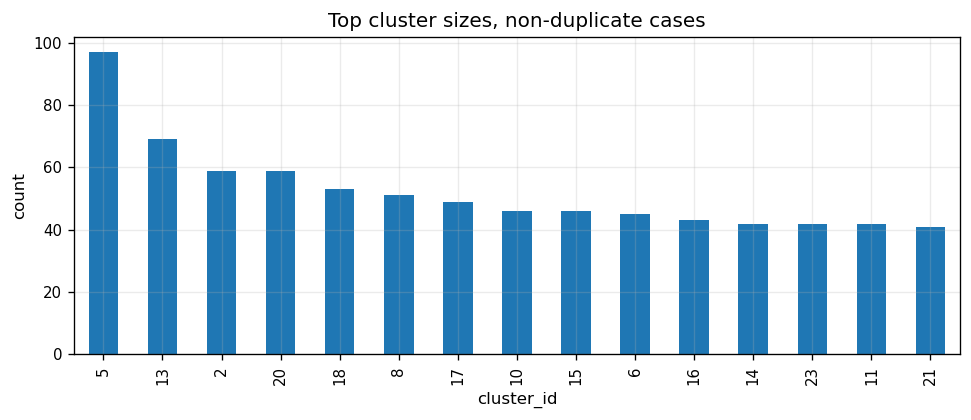

In [31]:
def deduplicate_cases(queue: pd.DataFrame) -> pd.DataFrame:
    q = queue.copy()
    q["dedup_key"] = q["recent_prompts"].map(lambda s: sha256_hex(normalize_text(s)) if s else "")
    q["is_dup"] = q.duplicated(subset=["day", "dedup_key"], keep="first").astype(int)
    return q

def cluster_cases(queue_nondup: pd.DataFrame, n_clusters: int = 25) -> pd.DataFrame:
    texts = queue_nondup["recent_prompts"].fillna("").astype(str).tolist()
    if len(texts) < 10:
        out = queue_nondup.copy()
        out["cluster_id"] = 0
        return out

    vect = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=2)
    X = vect.fit_transform(texts)
    k = min(n_clusters, max(2, int(len(texts) ** 0.5)))
    km = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1024)
    labels = km.fit_predict(X)

    out = queue_nondup.copy()
    out["cluster_id"] = labels
    return out

queue_dedup = deduplicate_cases(queue)
show_head(queue_dedup, "REVIEW QUEUE (DEDUP ANNOTATED)", truncate_cols=["recent_prompts"], max_len=140)

dup_frac = float(queue_dedup["is_dup"].mean()) if len(queue_dedup) else 0.0
print("\nDuplicate fraction in queue:", dup_frac)

clusters = cluster_cases(queue_dedup[queue_dedup["is_dup"] == 0], n_clusters=25)
show_head(clusters, "CLUSTERED CASES (NON-DUP)", truncate_cols=["recent_prompts"], max_len=140)

top_clusters = clusters["cluster_id"].value_counts().head(15)
tight_bar(top_clusters, "Top cluster sizes, non-duplicate cases", xlabel="cluster_id")

# 9. Entity resolution (link coordinated accounts) + component size plot
Constructs edges between users who share devices, payment tokens, or limited-fanout IPs, computes connected components using union-find, outputs an edge list and component membership table, and visualizes component size distribution.

Builds a network showing users that share the same device, payment token, or “reasonable” shared IP ranges, then finds groups of linked accounts that could be controlled by the same actor.


=== ENTITY RESOLUTION EDGES (shape=(5477, 4)) ===


,user_a,user_b,edge_type,edge_key
0,u_01181,u_01456,shared_ip,203.0.113.202
1,u_00712,u_01352,shared_ip,203.0.113.2
2,u_00571,u_00709,shared_ip,203.0.113.104
3,u_00637,u_00985,shared_payment,pay_000009
4,u_01080,u_01383,shared_ip,203.0.113.13



=== ENTITY RESOLUTION COMPONENTS (shape=(1500, 2)) ===


,user_id,component_id
0,u_00000,0
1,u_00001,0
2,u_00002,0
3,u_00003,0
4,u_00004,0


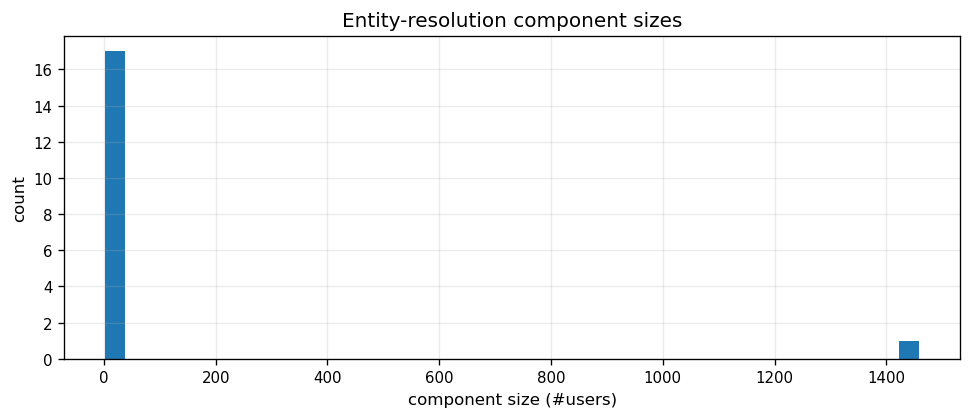

In [34]:
def entity_resolution(events: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    ev = events.copy()
    from collections import defaultdict

    user_ip = ev.groupby("user_id")["ip"].agg(lambda s: list(set(s))).to_dict()
    user_dev = ev.groupby("user_id")["device_id"].agg(lambda s: list(set(s))).to_dict()
    user_pay = ev.groupby("user_id")["payment_id"].agg(lambda s: list(set([x for x in s if pd.notna(x)]))).to_dict()

    ip_to_users = defaultdict(set)
    dev_to_users = defaultdict(set)
    pay_to_users = defaultdict(set)

    for u, ips in user_ip.items():
        for ip in ips:
            ip_to_users[ip].add(u)
    for u, devs in user_dev.items():
        for d in devs:
            dev_to_users[d].add(u)
    for u, pays in user_pay.items():
        for p in pays:
            pay_to_users[p].add(u)

    edges = set()

    def add_edges(users, edge_type, key):
        users = sorted(set(users))
        if len(users) < 2:
            return
        for i in range(len(users)):
            for j in range(i + 1, len(users)):
                edges.add((users[i], users[j], edge_type, key))

    for dev, us in dev_to_users.items():
        if len(us) >= 2:
            add_edges(us, "shared_device", dev)

    for pay, us in pay_to_users.items():
        if len(us) >= 2:
            add_edges(us, "shared_payment", pay)

    for ip, us in ip_to_users.items():
        if 2 <= len(us) <= 30:  # gate medium fanout IPs
            add_edges(us, "shared_ip", ip)

    edges_df = pd.DataFrame(list(edges), columns=["user_a", "user_b", "edge_type", "edge_key"])

    # union-find
    parent, rank = {}, {}

    def find(x):
        parent.setdefault(x, x)
        if parent[x] != x:
            parent[x] = find(parent[x])
        return parent[x]

    def union(a, b):
        ra, rb = find(a), find(b)
        if ra == rb:
            return
        rank.setdefault(ra, 0)
        rank.setdefault(rb, 0)
        if rank[ra] < rank[rb]:
            parent[ra] = rb
        elif rank[ra] > rank[rb]:
            parent[rb] = ra
        else:
            parent[rb] = ra
            rank[ra] += 1

    for _, r in edges_df.iterrows():
        union(r["user_a"], r["user_b"])

    users = sorted(ev["user_id"].unique().tolist())
    root_to_id = {}
    cid = 0
    comp_ids = []
    for u in users:
        root = find(u)
        if root not in root_to_id:
            root_to_id[root] = cid
            cid += 1
        comp_ids.append(root_to_id[root])

    comp_df = pd.DataFrame({"user_id": users, "component_id": comp_ids})
    return edges_df, comp_df

edges_df, comp_df = entity_resolution(events)
show_head(edges_df, "ENTITY RESOLUTION EDGES")
show_head(comp_df, "ENTITY RESOLUTION COMPONENTS")

comp_sizes = comp_df["component_id"].value_counts()
tight_hist(comp_sizes.rename("component_size"), "Entity-resolution component sizes", bins=40, xlabel="component size (#users)")

# Cell 10, Drift monitoring (PSI) + tight barh plot
Compares feature distributions in the most recent days versus earlier days using PSI, flags features with meaningful drift, prints a ranked drift table, and visualizes the top drifting features with a compact horizontal bar chart.

Compares recent days to earlier days to see if the data is shifting, which is a warning sign that models and rules might stop working well unless updated.


=== DRIFT (PSI) (shape=(12, 3)) ===


,feature,psi,drift_flag
0,n_events,0.044287,0
2,tokens_in_sum,0.022409,0
3,tokens_out_sum,0.020526,0
1,n_chat,0.019553,0
11,chat_fraction,0.010699,0


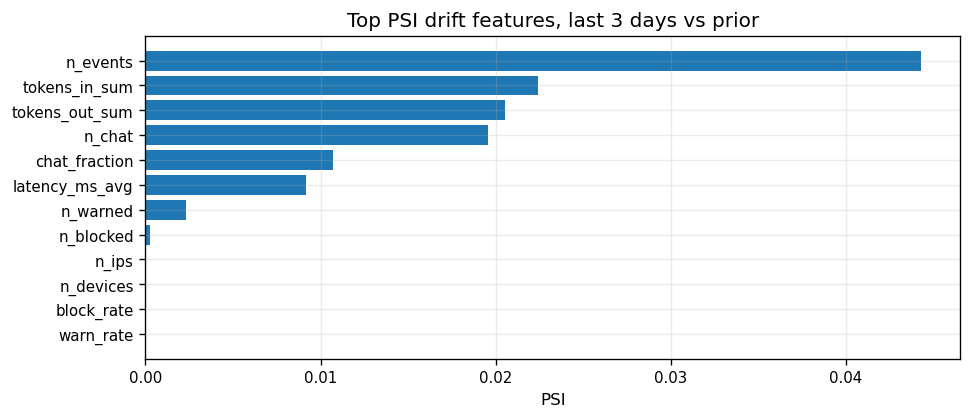

In [37]:
def compute_drift(df_ref: pd.DataFrame, df_cur: pd.DataFrame, feature_cols: List[str]) -> pd.DataFrame:
    rows = []
    for c in feature_cols:
        psi = population_stability_index(df_ref[c].values, df_cur[c].values, bins=10)
        rows.append({"feature": c, "psi": psi, "drift_flag": int(psi > 0.2)})
    return pd.DataFrame(rows).sort_values("psi", ascending=False)

df_sorted = df_scored.sort_values("day")
days = sorted(df_sorted["day"].unique().tolist())

if len(days) >= 6:
    df_ref = df_sorted[df_sorted["day"].isin(days[:-3])]
    df_cur = df_sorted[df_sorted["day"].isin(days[-3:])]
    drift = compute_drift(df_ref, df_cur, FEATURE_COLS)
else:
    drift = pd.DataFrame(columns=["feature", "psi", "drift_flag"])

show_head(drift, "DRIFT (PSI)")

if not drift.empty:
    top = drift.head(12).iloc[::-1]
    fig, ax = plt.subplots()
    ax.barh(top["feature"], top["psi"])
    ax.set_title("Top PSI drift features, last 3 days vs prior")
    ax.set_xlabel("PSI")
    fig.tight_layout()
    plt.show()

# Cell 11, Enforcement suggestions + incident log + save artifacts
Maps risk score and uncertainty into suggested actions (allow, warn, rate_limit, block, escalate), creates an incident stub if high-severity alerts exist, plots action counts, prints incident info, and saves all major artifacts as CSV plus the SQLite database for reproducibility.

Turns scores into suggested actions (allow, warn, rate limit, block, escalate), creates a simple incident record if something serious happened, plots action counts, and saves all outputs (CSVs + database) for sharing and reproducibility.


=== SUGGESTED ENFORCEMENT ACTIONS (shape=(2000, 6)) ===


,day,user_id,risk_score,uncertainty,suggested_action,reason_code
51,2026-02-10,u_01464,0.898818,0.202363,allow,below_threshold
64,2026-02-03,u_00038,0.898370,0.203259,allow,below_threshold
65,2026-02-09,u_01066,0.898149,0.203703,allow,below_threshold
66,2026-02-14,u_00096,0.897659,0.204682,allow,below_threshold
67,2026-02-04,u_01400,0.897010,0.205980,allow,below_threshold


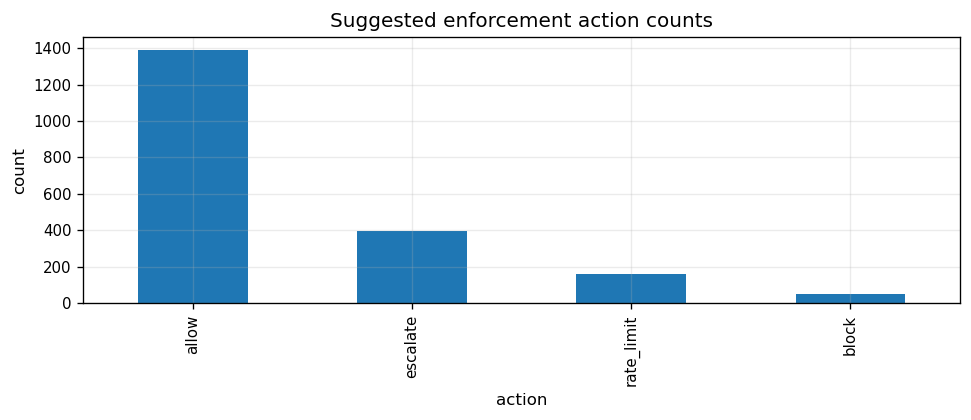

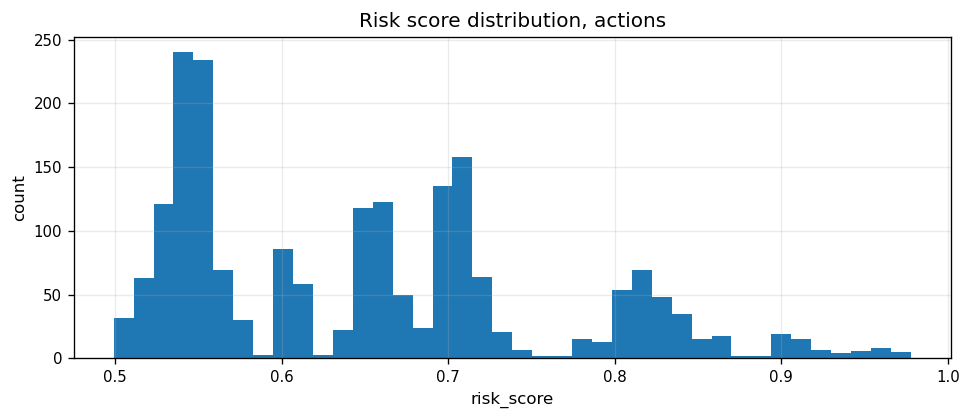


=== INCIDENT LOG (shape=(1, 6)) ===


,incident_id,created_ts,severity,summary,status,retrospective_stub
0,inc_1771133724,2026-02-15T05:35:24.711050+00:00,high,"2 high-severity alert(s), example spike_block_...",open,"{\n ""what_happened"": """",\n ""impact"": """",\n ..."


Saved outputs to: out_notebook


In [40]:
def decide_enforcement(queue: pd.DataFrame) -> pd.DataFrame:
    actions = []
    for _, r in queue.iterrows():
        score = float(r["risk_score"])
        unc = float(r["uncertainty"])
        block_rate = float(r.get("block_rate", 0.0))
        n_chat = int(r.get("n_chat", 0))
        recent = str(r.get("recent_prompts", ""))

        if score >= 0.90 and unc <= 0.35:
            act, reason = "block", "high_confidence_abuse"
        elif score >= 0.75 and (block_rate >= 0.10 or "bypass" in recent or "evade" in recent):
            act, reason = "rate_limit", "policy_evasion_or_repeat"
        elif score >= 0.55 and unc >= 0.75:
            act, reason = "escalate", "uncertain_high_risk"
        elif score >= 0.50 and n_chat >= 80:
            act, reason = "warn", "suspicious_burst"
        else:
            act, reason = "allow", "below_threshold"

        actions.append({
            "day": r["day"],
            "user_id": r["user_id"],
            "risk_score": score,
            "uncertainty": unc,
            "suggested_action": act,
            "reason_code": reason
        })

    return pd.DataFrame(actions).sort_values(["suggested_action", "risk_score"], ascending=[True, False])

def create_incident_if_needed(alerts: pd.DataFrame) -> pd.DataFrame:
    if alerts.empty:
        return pd.DataFrame(columns=["incident_id", "created_ts", "severity", "summary", "status", "retrospective_stub"])
    high = alerts[alerts["severity"] == "high"]
    if high.empty:
        return pd.DataFrame(columns=["incident_id", "created_ts", "severity", "summary", "status", "retrospective_stub"])

    incident_id = f"inc_{int(time.time())}"
    created_ts = utcnow().isoformat()
    summary = f"{len(high)} high-severity alert(s), example {high.iloc[0]['alert_type']} on {high.iloc[0]['day']}"
    retrospective = {
        "what_happened": "",
        "impact": "",
        "root_cause_hypothesis": "",
        "mitigations_applied": "",
        "followups": ["Tune thresholds", "Backtest detectors", "Improve enrichment", "Ship prevention and validate"],
        "owner": "",
        "due_date": ""
    }
    return pd.DataFrame([{
        "incident_id": incident_id,
        "created_ts": created_ts,
        "severity": "high",
        "summary": summary,
        "status": "open",
        "retrospective_stub": json.dumps(retrospective, indent=2),
    }])

actions = decide_enforcement(queue_dedup)
show_head(actions, "SUGGESTED ENFORCEMENT ACTIONS")

tight_bar(actions["suggested_action"].value_counts(), "Suggested enforcement action counts", xlabel="action")
tight_hist(actions["risk_score"].rename("risk_score"), "Risk score distribution, actions", bins=40)

incident_log = create_incident_if_needed(alerts)
show_head(incident_log, "INCIDENT LOG", truncate_cols=["retrospective_stub"], max_len=160)

# Save outputs (good for GitHub)
events.to_csv(os.path.join(OUTDIR, "raw_events.csv"), index=False)
metrics.to_csv(os.path.join(OUTDIR, "monitoring_metrics.csv"), index=False)
alerts.to_csv(os.path.join(OUTDIR, "alerts.csv"), index=False)
df_scored.to_csv(os.path.join(OUTDIR, "user_day_scored.csv"), index=False)
queue.to_csv(os.path.join(OUTDIR, "review_queue.csv"), index=False)
audit.to_csv(os.path.join(OUTDIR, "audit_log_template.csv"), index=False)
queue_dedup.to_csv(os.path.join(OUTDIR, "review_queue_dedup.csv"), index=False)
clusters.to_csv(os.path.join(OUTDIR, "clusters.csv"), index=False)
edges_df.to_csv(os.path.join(OUTDIR, "entity_resolution_edges.csv"), index=False)
comp_df.to_csv(os.path.join(OUTDIR, "entity_resolution_components.csv"), index=False)
actions.to_csv(os.path.join(OUTDIR, "enforcement_actions.csv"), index=False)
incident_log.to_csv(os.path.join(OUTDIR, "incident_log.csv"), index=False)

print("Saved outputs to:", OUTDIR)

# Cell 12, One-page executive summary (single compact table + a few tight highlights)
Builds a single compact table summarizing the whole run (data volume, monitoring rates, detector behavior, queue stats, clusters, entity-resolution components, alert and incident counts), and prints the top risky cases, largest linked-actor components, and largest case clusters for fast situational awareness.

Creates one compact “status report” table that sums up everything, then shows the top risky cases, biggest linked-account groups, and biggest clusters, basically a quick brief for on-call or leadership.

In [45]:
def pct(x, denom):
    return float(x) / float(denom) if denom else 0.0

def safe_head_series(s: pd.Series, n: int = 5) -> str:
    if s is None or len(s) == 0:
        return ""
    parts = []
    for k, v in s.head(n).items():
        if isinstance(v, float):
            parts.append(f"{str(k)}:{v:.4g}")
        else:
            parts.append(f"{str(k)}:{v}")
    return "; ".join(parts)

def executive_summary_table(
    events: pd.DataFrame,
    metrics: pd.DataFrame,
    alerts: pd.DataFrame,
    df_scored: pd.DataFrame,
    queue: pd.DataFrame,
    queue_dedup: pd.DataFrame,
    clusters: pd.DataFrame,
    edges_df: pd.DataFrame,
    comp_df: pd.DataFrame,
    actions: pd.DataFrame,
    incident_log: pd.DataFrame
) -> pd.DataFrame:

    # Basics
    n_events = len(events)
    n_users = events["user_id"].nunique()
    n_days = events["ts"].dt.floor("D").nunique()
    n_chats = int((events["event_type"] == "chat").sum())
    n_blocks = int(events["blocked"].sum())
    n_warns = int(events["warned"].sum())
    gt_abuse_users = int(events.groupby("user_id")["is_abuse_gt"].max().sum())

    # Monitoring
    avg_block_rate = float(metrics["block_rate"].mean()) if len(metrics) else 0.0
    avg_warn_rate = float(metrics["warn_rate"].mean()) if len(metrics) else 0.0
    peak_block_rate = float(metrics["block_rate"].max()) if len(metrics) else 0.0
    peak_warn_rate = float(metrics["warn_rate"].max()) if len(metrics) else 0.0

    # Model / detection
    model_thr = thr  # from earlier cell
    flagged_ml = int((df_scored["risk_score"] >= model_thr).sum())
    flagged_ml_rate = pct(flagged_ml, len(df_scored))

    mean_risk = float(df_scored["risk_score"].mean()) if len(df_scored) else 0.0
    p95_risk = float(df_scored["risk_score"].quantile(0.95)) if len(df_scored) else 0.0
    mean_unc = float(df_scored["uncertainty"].mean()) if len(df_scored) else 0.0

    # Queue
    n_queue = len(queue)
    dup_frac = float(queue_dedup["is_dup"].mean()) if len(queue_dedup) else 0.0
    n_nondup = int((queue_dedup["is_dup"] == 0).sum()) if len(queue_dedup) else 0
    top_recent = safe_head_series(
        queue.sort_values("risk_score", ascending=False)["recent_prompts"].fillna("").map(lambda s: _truncate_str(s, 90))
        .value_counts(),
        n=3
    )

    # Clusters
    n_clusters = clusters["cluster_id"].nunique() if ("cluster_id" in clusters.columns and len(clusters)) else 0
    top_cluster_sizes = safe_head_series(clusters["cluster_id"].value_counts(), n=5) if n_clusters else ""

    # Entity resolution
    n_edges = len(edges_df)
    n_components = comp_df["component_id"].nunique() if len(comp_df) else 0
    comp_sizes = comp_df["component_id"].value_counts() if len(comp_df) else pd.Series(dtype=int)
    largest_component = int(comp_sizes.max()) if len(comp_sizes) else 0
    top_components = safe_head_series(comp_sizes.head(5), n=5) if len(comp_sizes) else ""

    # Enforcement
    action_counts = actions["suggested_action"].value_counts() if len(actions) else pd.Series(dtype=int)
    action_summary = safe_head_series(action_counts, n=6)

    # Alerts / incidents
    n_alerts = len(alerts)
    alerts_by_type = safe_head_series(alerts["alert_type"].value_counts(), n=6) if len(alerts) else ""
    n_incidents = len(incident_log)

    rows = [
        ("Data", "Total events", n_events),
        ("Data", "Unique users", n_users),
        ("Data", "Days covered", n_days),
        ("Data", "Chat events", n_chats),
        ("Data", "Blocks (events)", n_blocks),
        ("Data", "Warnings (events)", n_warns),
        ("Data", "GT abuse users (synthetic)", gt_abuse_users),

        ("Monitoring", "Avg block rate", round(avg_block_rate, 4)),
        ("Monitoring", "Peak block rate", round(peak_block_rate, 4)),
        ("Monitoring", "Avg warn rate", round(avg_warn_rate, 4)),
        ("Monitoring", "Peak warn rate", round(peak_warn_rate, 4)),

        ("Detection", "Model threshold", round(float(model_thr), 4)),
        ("Detection", "ML-flagged user-days", flagged_ml),
        ("Detection", "ML-flagged rate", round(flagged_ml_rate, 4)),
        ("Detection", "Mean risk score", round(mean_risk, 4)),
        ("Detection", "95th percentile risk", round(p95_risk, 4)),
        ("Detection", "Mean uncertainty", round(mean_unc, 4)),

        ("Review Ops", "Queue size", n_queue),
        ("Review Ops", "Duplicate fraction", round(dup_frac, 4)),
        ("Review Ops", "Non-duplicate cases", n_nondup),
        ("Review Ops", "Top repeated prompts", top_recent),

        ("Automation", "Cluster count (non-dup)", n_clusters),
        ("Automation", "Top cluster sizes", top_cluster_sizes),

        ("Networks", "Entity edges", n_edges),
        ("Networks", "Connected components", n_components),
        ("Networks", "Largest component size", largest_component),
        ("Networks", "Top component sizes", top_components),

        ("Enforcement", "Action counts", action_summary),

        ("Incidents", "Alerts total", n_alerts),
        ("Incidents", "Alerts by type", alerts_by_type),
        ("Incidents", "Incidents created", n_incidents),
    ]

    out = pd.DataFrame(rows, columns=["Section", "Metric", "Value"])
    return out

summary_df = executive_summary_table(
    events=events,
    metrics=metrics,
    alerts=alerts,
    df_scored=df_scored,
    queue=queue,
    queue_dedup=queue_dedup,
    clusters=clusters,
    edges_df=edges_df,
    comp_df=comp_df,
    actions=actions,
    incident_log=incident_log
)

show_head(summary_df, "EXECUTIVE SUMMARY (ONE-PAGE)", n=60)

# Tight highlights: top risky cases (clean)
top_risky = queue.sort_values("risk_score", ascending=False).head(10).copy()
top_risky["recent_prompts"] = top_risky["recent_prompts"].map(lambda s: _truncate_str(s, 140))
show_head(top_risky[["day","user_id","risk_score","uncertainty","n_chat","n_blocked","n_warned","n_ips","n_devices","recent_prompts"]],
          "TOP 10 RISKIEST QUEUE ITEMS", n=10, truncate_cols=["recent_prompts"], max_len=140)

# Tight highlights: top components
if len(comp_df):
    comp_sizes = comp_df["component_id"].value_counts().head(10)
    comp_sizes_df = comp_sizes.reset_index()
    comp_sizes_df.columns = ["component_id","size"]
    show_head(comp_sizes_df, "TOP 10 LINKED-ACTOR COMPONENTS", n=10)

# Tight highlights: top clusters
if "cluster_id" in clusters.columns and len(clusters):
    cl_sizes = clusters["cluster_id"].value_counts().head(10)
    cl_df = cl_sizes.reset_index()
    cl_df.columns = ["cluster_id","size"]
    show_head(cl_df, "TOP 10 CASE CLUSTERS (NON-DUP)", n=10)


=== EXECUTIVE SUMMARY (ONE-PAGE) (shape=(31, 3)) ===


,Section,Metric,Value
0,Data,Total events,50000
1,Data,Unique users,1500
2,Data,Days covered,15
3,Data,Chat events,31715
4,Data,Blocks (events),2137
5,Data,Warnings (events),2164
6,Data,GT abuse users (synthetic),60
7,Monitoring,Avg block rate,0.0685
8,Monitoring,Peak block rate,0.0882
9,Monitoring,Avg warn rate,0.0679



=== TOP 10 RISKIEST QUEUE ITEMS (shape=(10, 10)) ===


,day,user_id,risk_score,uncertainty,n_chat,n_blocked,n_warned,n_ips,n_devices,recent_prompts
6,2026-02-14,u_01267,0.977803,0.044394,2,1,2,1,1,join our group and earn money quickly!!! | lim...
1,2026-02-12,u_01144,0.976138,0.047725,4,1,2,1,1,how do i bypass content filters? | click this ...
3,2026-02-11,u_01416,0.975871,0.048258,3,1,2,1,1,join our group and earn money quickly!!! | joi...
2,2026-02-11,u_00334,0.975657,0.048685,4,1,2,1,1,can you help me evade detection systems? | gen...
5,2026-02-13,u_00178,0.968299,0.063402,3,2,2,1,1,translate this paragraph into spanish. | expla...
9,2026-02-03,u_00747,0.963431,0.073138,3,2,1,1,1,join our group and earn money quickly!!! | gen...
4,2026-02-01,u_00697,0.961215,0.077570,4,2,0,1,1,join our group and earn money quickly!!! | buy...
11,2026-02-03,u_00231,0.960187,0.079626,3,2,0,1,1,make a study plan for learning linear algebra....
12,2026-02-08,u_00818,0.959160,0.081681,3,2,0,1,1,can you help me evade detection systems? | sum...
13,2026-02-13,u_01043,0.958802,0.082396,3,2,0,1,1,can you help me evade detection systems? | how...



=== TOP 10 LINKED-ACTOR COMPONENTS (shape=(10, 2)) ===


,component_id,size
0,0,1459
1,5,5
2,4,4
3,1,4
4,11,2
5,16,2
6,15,2
7,14,2
8,13,2
9,12,2



=== TOP 10 CASE CLUSTERS (NON-DUP) (shape=(10, 2)) ===


,cluster_id,size
0,5,97
1,13,69
2,2,59
3,20,59
4,18,53
5,8,51
6,17,49
7,10,46
8,15,46
9,6,45


# The tables and figures imply a realistic “abuse defense loop”:
	1.	We can see what is happening (monitoring and alerts).
	2.	We can prioritize what matters (risk scores and PR tradeoffs).
	3.	We can handle uncertainty safely (send unclear cases to human decision).
	4.	We can scale human review (dedup and clustering).
	5.	We can find coordinated attackers (entity resolution).
	6.	We can keep the system working over time (drift checks).
	7.	We can operate like a real team (audit logs, incident stubs, action tables).

The results show the system can spot abnormal behavior early, rank and route the riskiest cases to humans with context, group repeated patterns, link coordinated accounts, and stay reliable over time.